# Model Designation

The model developed in this use case belongs to the class of non-probabilistic supervised deep learning models for solving regression tasks. Here are further explanations regarding the class designation of the model.

- Supervised means that there is a reference against which performance of the model can be objectivley evaluated, within a formal protocol for evaluating models for solving regression tasks.

- Deep learning means that the model will be based on the technology of artificial neural networks (ANNs), which significantly differs in comparison to the classical ML models, when it comes to the methodology of model training and testing, usage of computational resources, and most importantly, logic for making inferences which model obtains after completion of training process.

- Regression means that the objective of a model is to predict numerical values (members of the set of real numbers) which originte from a continous distribution. (As opposed to classification tasks in which the objective is to predict the integers originating from discrete distribution.)

- The model that will be developed is not able to (a) generate data, or (b) give an uncertianty estimate, and therefore it is designated as non-probabilistic.

# Objective of Learning Task

Objective of the learning task is to predict the "temperature in kitchen area" in degrees of Celsius, on the basis of other variables present in the "Appliances energy prediction Data Set" available from the UCI Machine Learning Repository. Reader is encouraged to get more information about the data set in question, having in mind that the emphasis of this use case is on developent of recurrent neural network (RNN), rather than on data analysis and data exploration.

# Technology Stack

Python programing language has been selected for the purposes of model development. Virtualenv package is utilized for generation of specific environment. Model development is done in Keras, while computatuion is done in TensorFlow, with Eigen as the BLAS computational backend. Data manitpulation is mostly done in numpy because there is there is no pronunced need to use named feature and target vectors. Usage of these technologies is encouraged in order to get repodocuible results.

# Methodology of Model Training and Testing

Modeling process follows basic methodology for training and testing of models which solve regression tasks.

- The data set is split to training, validation, and testing set.
- A simplistic LSTM RNN is constructed and trained.
- Training process continues until no reduction of loss on validation set is recorded for two non-consecutive epoch. Minimal increase in reduction of loss, that needs to be achieved between two non-consecutive epochs, is 0.01 MSE.
- After completion of the training process, model performance is evaluated on the test set. Main component of model performance is its accuracy, which is measured as mean absolute error (MAE). Model generalization ability, as the second component of the model performance, is only briefly evaluated.
- Finally, alongside the evaluation of model accuracy, a comparison is done between a fit produces by a FFD ANN developed previousley, and LSTM RNN.

No cross-validation or model fine tuning is performed. The reasoning behind such a simplistic approach to model training and testing, is driven by limitations of the model development environment, especially in the terms of computational resources. Therefore, methodology of model training and testing is designed to meet the requirements of fast development and low computational effort, rather than designed to find best solution in terms of model's generalization ability and accuracy. Model training and testing proces would greatly benefit from introduction of hyper-parameter tuning and cross validation.

Also, it is important to take into account that the main purpose of the use-case is to gain insight into preformance of LSTM RNN in comparison to the FFD ANN. Having in mind that the time series data is used in the use-case, expected outcome is to observe advantages of LSTM RNN over FFD ANNs.


# Model Development

First step is to import necessary packages.

In [100]:
import pandas as pd
import numpy as np
from math import floor
from collections import OrderedDict
from keras.models import load_model
from keras.layers import Input, Dense, LSTM
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid

Now, we proceed with declaration of a class for data holding the names of the features and targets. This class also preforms basic data preparation, hence the name of the class. However, further preparation of the data is performed downstream as well.

In [101]:
class PreparedData:
    def __init__(self, inn):
        self.original_data = inn
        self.prepared_data = None
        self.feature_labels = None
        self.target_labels = None
        # Assign index and convert to date.
        out = inn.copy(deep=True)
        out.index = pd.to_datetime(inn['date'])
        # Drop unnecessary columns.
        out.drop(columns=['date', 'rv1', 'rv2'], inplace=True)
        # Get labels.
        target_labels = [
            label for label in inn.columns if
            ('T1' in label)
            & ('_out' not in label)
            & ('Tdewpoint' not in label)
        ]
        feature_labels = set(out.columns) - set(target_labels)
        self.prepared_data = out
        self.feature_labels = feature_labels
        self.target_labels = target_labels

The purpose of the following function is to create a subset of data by selecting desired columns.

In [102]:
def subset_columns(frame, columns):
    """
    Return numpy array wh. subset of columns.
    """
    return np.array(frame.loc[:, columns])

Previous function is then followed with two utility functions. One, to make feature data sets.

In [103]:
def make_features(training_frame,
                  validation_frame,
                  testing_frame,
                  feature_columns):
    """
    Return a features for training, validation, and testing.
    """
    return (
        subset_columns(
            frame=training_frame,
            columns=feature_columns,
        ),
        subset_columns(
            frame=validation_frame,
            columns=feature_columns,
        ),
        subset_columns(
            frame=testing_frame,
            columns=feature_columns
        )
    )

And another to make targets data sets.

In [104]:
def make_targets(training_frame,
                 validation_frame,
                 testing_frame,
                 targets_columns):
    """
    Return a features for training, validation, and testing.
    """
    return (
        subset_columns(
            frame=training_frame,
            columns=targets_columns,
        ),
        subset_columns(
            frame=validation_frame,
            columns=targets_columns,
        ),
        subset_columns(
            frame=testing_frame,
            columns=targets_columns
        )
    )

Utility funcitions are complemented with the function to standardize data.

In [105]:
def compute_mean_and_standard_deviation(table):
    """
    Return mean and standard deviation of the table.
    """
    return np.mean(table, axis=0), np.std(table, axis=0)

Now we get into functions specific for the usage of RNNs. First in line, is a function that reshapes an array into a shape that can be ingested into a RNN (samples, time-steps, dimensions). In the vocabulary of the function, the length of the sequence (number of the time-steps) is designated as "memory", in order to emphaisise the capacity of the network to absorb temporal data.

In [106]:
def reshape_features_for_rnn(input_array, memory):
    """
    Return features reshaped to the required dimensionality.
    """
    feasible_duration_of_training_set = len(input_array[memory:, :])
    # Number of samples.
    total_samples = floor(feasible_duration_of_training_set / memory)
    # Subset features, so that there is enough timestamps for all samples.
    # and return with the new shape.
    return np.reshape(
        input_array[0:memory*total_samples, :],
        newshape=(
            total_samples, memory, np.shape(input_array)[1]
        )
    )


Now we go into a series of generators which yield baches. The first in line is the generator for the training process. This generator yields batches of featurea and targets. For the generaor to work it is necessary to firstly create an inventory of batches, which will be passed to the generator as an input. Production of individual batches is done via call to the function defined above.

In [144]:
def generate_batch(features, labels, inventory_of_batches, samples_per_batch):
    """
    Return a batch of features and targets of desired size.
    """
    while True:
        for batch in inventory_of_batches.index:
            feature_sample_start = \
                inventory_of_batches['features_start'][batch]
            feature_sample_end = \
                inventory_of_batches['features_end'][batch]
            target_sample_start = \
                inventory_of_batches['targets_start'][batch]
            target_sample_end = \
                inventory_of_batches['targets_end'][batch]
            features_batch = np.reshape(
                features[feature_sample_start:feature_sample_end, :],
                newshape=(
                    samples_per_batch,
                    memory,
                    np.shape(x_test_standardized)[1]
                )
            )
            targets_batch = np.reshape(
                 labels[target_sample_start:target_sample_end, ],
                 newshape=(samples_per_batch, 1)
            )
            yield (
                {'input_layer': features_batch},
                {'output_layer': targets_batch}
            )


Next in line is the generator of the batches for the prediction process. What is the difference between this generator, and the first one? This generator yields only features, and no targets. Everything else is the same.

In [108]:
def generate_batch_for_prediction(features, inventory_of_batches):
    """
    Return a batch of features and targets of desired size.
    """
    while True:
        for batch in inventory_of_batches.index:
            feature_sample_start = \
                inventory_of_batches['features_start'][batch]
            feature_sample_end = \
                inventory_of_batches['features_end'][batch]
            features_batch = np.reshape(
                features[feature_sample_start:feature_sample_end, :],
                newshape=(1, memory, np.shape(x_test_standardized)[1])
            )
            yield ({'input_layer': features_batch})

Now there are only two things left. First one is to create a function to make the LSMT RNN.

In [109]:
def get_lstm_rnn_model(capacity, dimensionality):
    """
    Return model.
    """
    # Declare input layer.
    input_layer = Input(shape=(capacity, dimensionality), name='input_layer')
    # Declare regression layer 1.
    regression_1 = LSTM(
        units=2,
        unit_forget_bias=True,
        return_sequences=True,
        stateful=False,
        implementation=1
    )(input_layer)
    # Declare regression layer 2.
    regression_2 = LSTM(
        units=2,
        unit_forget_bias=True,
        return_sequences=False,
        stateful=False,
        implementation=1
    )(regression_1)
    output = Dense(1, activation='linear', name='output_layer')(regression_2)
    return Model(inputs=input_layer, outputs=output)

And also to create a function the generate predictions form the FFD ANN.

In [110]:
def get_stochastic_predictions(model_for_deployment, input_data, passes):
    """
    Return stochastic predictions according to desired number of passes.
    """
    # Declare a list to store predictions.
    raw_predictions = []
    for forward_pass in range(passes):
        raw_predictions.append(
            model_for_deployment.predict(
                x=input_data, batch_size=len(input_data), verbose=0)
        )
    return np.transpose(np.reshape(
        raw_predictions, newshape=(passes, len(input_data))
    ))

Without further ado, let us move on to the mode development.

In [111]:
if __name__ == '__main__':

    # Declare file handles.
    RAW_DATA = r'M:\Projects\004_mc_dropout\1_data\energydata_complete.csv'
    FFD_ANN_FOLDER = r'M:\Projects\004_mc_dropout\3_output'

    # Get data.
    raw_data = pd.read_csv(RAW_DATA, sep=',')

    # Prepare data.
    data_preparation = PreparedData(inn=raw_data)
    prepared_data = data_preparation.prepared_data

Firstly, the data is imported and prepared. Then, we declare start and end timestamps for training, validation, and testing sets.

In [112]:
    # Declare limits for subsets of data set.
    training_start = 0
    training_end = int(len(prepared_data)/2 - len(prepared_data)/2*.1)
    validation_start = int(len(prepared_data)/2 - len(prepared_data)/2*.1)
    validation_end = int(len(prepared_data)/2)
    testing_start = int(len(prepared_data)/2)
    testing_end = len(prepared_data)

Training data is then subsetted.


In [113]:
    # Subset samples for training.
    features_and_targets_for_training = \
        prepared_data.iloc[training_start:training_end, :]

And here we can see the start, and end timestamps.

In [114]:
    # Print starting and ending times.
    print('Start of training: %s. End of training: %s.' % (
        features_and_targets_for_training.index[0],
        features_and_targets_for_training.index[-1]
    ))

Start of training: 2016-01-11 17:00:00. End of training: 2016-03-13 08:50:00.


Now we can also subset the validation and testing data.

In [115]:
    # Subset samples for validation.
    features_and_targets_for_validation = \
        prepared_data.iloc[validation_start:validation_end, :]

    # Subset samples for testing.
    features_and_targets_for_testing = \
        prepared_data.iloc[testing_start:testing_end, :]

And examine start time-stamps and end time-stapms of these sections of the data.

In [116]:
    print('Start of validation: %s. End of validation: %s.' % (
        features_and_targets_for_validation.index[0],
        features_and_targets_for_validation.index[-1]
    ))
    print('Start of testing: %s. End of testing: %s.' % (
        features_and_targets_for_testing.index[0],
        features_and_targets_for_testing.index[-1]
    ))

Start of validation: 2016-03-13 09:00:00. End of validation: 2016-03-20 05:20:00.
Start of testing: 2016-03-20 05:30:00. End of testing: 2016-05-27 18:00:00.


As mentioned in the introduction, the purpose of the use case is to make comparison betwenn FFD ANN and LSTM RNN. Therefore, we firts need to generate predictions from the FFD ANN model, and to do that we need to prepare the data in the same way that the data was prepared for the training of FFD ANN. So we will start with loading of the scaling parameters.

In [117]:
    # Get FFD ANN model scaling parameters.
    ffd_ann_scaling_parameters = pd.read_csv(
        filepath_or_buffer=
            FFD_ANN_FOLDER+r'\uc004_mc_dropout_scaling_parameters.csv',
        index_col=0
    )

Then, we will make features and targets but with special consideration to the order of the variables. That is the purpose of the reference to "variable_names" column of the scaling parmeters data frame. This column, holds the order of the variables.

In [118]:
    # Get features.
    features_training, features_validation, features_testing = \
        make_features(
            training_frame=features_and_targets_for_training,
            validation_frame=features_and_targets_for_validation,
            testing_frame=features_and_targets_for_testing,
            feature_columns=ffd_ann_scaling_parameters['variable_name'],
        )

    # Get targets.
    targets_train, targets_validation, targets_test = make_targets(
        training_frame=features_and_targets_for_training,
        validation_frame=features_and_targets_for_validation,
        testing_frame=features_and_targets_for_testing,
        targets_columns=data_preparation.target_labels,
    )

Now all that there is left is to get the actual scaling parameters (mean, and standard deviation) and to standardize the data.

In [119]:
    # Get mean and standard deviation of training features.
    mean = ffd_ann_scaling_parameters['mean'].values
    standard_deviation = \
        ffd_ann_scaling_parameters['standard_deviation'].values
    # Standardize training, validation, and testing features.
    x_train_standardized = (features_training-mean) / standard_deviation
    x_validation_standardized = (features_validation-mean) / standard_deviation
    x_test_standardized = (features_testing-mean) / standard_deviation

Let us verify if the standardization was done correclty.

In [120]:
    # Print variance of the features.
    print(np.var(x_train_standardized, axis=0))
    print(np.var(x_validation_standardized, axis=0))
    print(np.var(x_test_standardized, axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
[1.18307181 0.6743218  0.16078519 1.3665739  0.20565271 0.54285796
 1.15865454 0.87941373 0.27765162 0.06666029 0.0703394  0.41331868
 0.65862733 0.10223157 0.3124564  0.74120142 1.93688439 0.25435944
 0.75422202 0.04869117 1.09058073 0.30501772 0.58681752 0.41685807
 0.16557348]
[0.78632384 2.10412644 1.85421244 2.09215122 0.64130847 1.73711587
 2.28147666 0.41874729 0.71785236 0.369263   0.62236422 0.52631285
 0.76336401 0.81455222 1.12648601 2.5185316  0.536103   0.92568494
 1.70935316 2.49731804 1.6243543  1.36839702 1.75868663 0.60882017
 0.61950162]


As it can be seen, the standardization is done correctly. The shift in distribution of the input data is already known characteristic of this data set. Now, we get the FFD ANN.

In [121]:
    # Get FFD ANN model.
    ffd_ann_model = load_model(
        filepath=FFD_ANN_FOLDER+r'\uc004_mc_dropout_model.h5'
    )

And generate some predictions out of FFD ANN.

In [122]:
    ffd_ann_predictions = get_stochastic_predictions(
        model_for_deployment=ffd_ann_model,
        input_data=x_test_standardized,
        passes=30
    )
    ffd_ann_predictions = np.mean(ffd_ann_predictions, axis=1)

Let us recall what was the accracy of the FFD ANN.

In [123]:
     # Compute MAE.
    ffd_ann_mae = np.round(
        np.mean(np.abs(targets_test.flatten()-ffd_ann_predictions)),
        decimals=2
    )
    print(ffd_ann_mae)

0.75


Not a bad result 0.75 Celsius. Let us now move on to set-up LSTM RNN. Firstly, we need to declare how much will be the memory (ie. storage) capacity of the LSTM RNN. We will set it to 30 time-steps.

In [124]:
    # Declare how much memory is needed for prediction?
    memory = 30

The next thing to declare is the prediction interval, or how often we need to make predictions. Let assume that predictions need to be made at every timestep.

In [125]:
    # Declare prediction interval.
    prediction_interval = 1

Another name for the prediction interval, cold be prediction frequency. Apart, from predicion interval, we also need the length of prediction, or how many time-steps will be predicted every time the model is executed.

In [126]:
    # Prediction length.
    prediction_length = 1

We declare prediction length to 1 time-step. Now, how we can state the problem the network is trying to solve? Given the last 30 time-steps of data in the features (memory), predict the "temperature int the kitchen area" at the next (31st) time-step (prediction length), once per every time-step (prediction interval). Please note that there is no delay between the memory and prediction. As soon as the 30 time-steps is consumed, prediction for the 31st time-step is made. (The problem could be specified with a longer delay.) Also note that there is no down-sampling of the input features. (All 30 time-steps are taken into account when performing prediction). Finally, the length of predicion could be increased, to more than one. Now, we need to declare some paramaters which will be utilized in training.

In [127]:
    # Batch size.
    samples_per_batch = 1
    batch_length = samples_per_batch * memory

We need to declare how many samples will be witin the batch. In this case each batch will contain only one sample. Batch length is just a total ength of each batch given the number of samples within the batch and memory capacity of the network. Again, this is one of the tuning parameters, or better yet--design decisions--on how to construct model training and deployment process. Please, also note that in this setup introduction of more than one sample within a batch will mean that there will be overalapping of the time-steps among the batches. After decalring these basic parameters of model deployment and training process, we need to determine derived inputs for the trining process.

In [128]:
    # Compute maximal number of samples.
    training_samples = len(x_train_standardized) - batch_length
    validation_samples = len(x_validation_standardized) - batch_length
    testing_samples = len(x_test_standardized) - batch_length

Finally, we build an inventory of the training indices which will utilized by the fit generator to yield batches of samples for the features and targets.

In [129]:
    # Indices for training.
    training_indices_features = pd.DataFrame(OrderedDict([
        (
            'features_start',
            list(range(0, training_samples, samples_per_batch))
        ), (
            'features_end',
            list(range(
                batch_length,
                batch_length+training_samples,
                samples_per_batch
            ))
        ), (
            'targets_start',
            list(range(
                batch_length,
                batch_length+training_samples,
                samples_per_batch
            ))
        ), (
            'targets_end',
            list(range(
                batch_length+samples_per_batch,
                batch_length+samples_per_batch+training_samples,
                samples_per_batch
            ))
        )
    ]))

Befor we complete this inventory, we need to make sure that there are no implausible indices.

In [130]:
    # Check.
    training_indices_features['check'] = \
        np.where(
            training_indices_features['targets_end'] > len(targets_train), 1, 0
        )
    training_indices_features = training_indices_features.loc[
        training_indices_features['check'] == 0, :
    ]

At the very end we will shuffle the indices. Please note that (a) only the indices are shuffled, and not the arrays that contain data, and that (b) the whole batches are shuffled and not the individual samples within the batches. 

In [131]:
    # Shuffle training indices.
    shuffle = np.random.randint(
        low=0,
        high=len(training_indices_features),
        size=len(training_indices_features),
        dtype=np.int
    )
    training_indices_features = training_indices_features.iloc[shuffle, :]
    training_indices_features.reset_index(inplace=True, drop=True)

With the exception of shuffling we repeat this indexing process for both validation data, and testing data.

In [132]:
    # Validation indices.
    validation_indices = pd.DataFrame(OrderedDict([
        (
            'features_start',
            list(range(0, validation_samples, prediction_length))
        ), (
            'features_end',
            list(range(
                batch_length,
                batch_length+validation_samples,
                prediction_length
            ))
        ), (
            'targets_start',
            list(range(
                batch_length,
                batch_length+validation_samples,
                prediction_length
            )),
        ), (
            'targets_end',
            list(range(
                batch_length+samples_per_batch,
                batch_length+samples_per_batch+validation_samples,
                prediction_length
            ))
        )
    ]))

    # Check.
    validation_indices['check'] = \
        np.where(
            validation_indices['targets_end'] > len(targets_validation), 1, 0
        )
    validation_indices = validation_indices.loc[
        validation_indices['check'] == 0, :
    ]

    # Testing indices.
    testing_indices = pd.DataFrame(OrderedDict([
        (
            'features_start',
            list(range(0, testing_samples, prediction_length))
        ), (
            'features_end',
            list(range(
                memory,
                memory+testing_samples,
                prediction_length
            ))
        ), (
            'targets_start',
            list(range(
                memory,
                memory+testing_samples,
                prediction_length
            ))
        ), (
            'targets_end',
            list(range(
                memory+samples_per_batch,
                memory+samples_per_batch+testing_samples,
                prediction_length
            ))
        )
    ]))

    # Check.
    testing_indices['check'] = \
        np.where(
            testing_indices['features_end'] > len(x_test_standardized), 1, 0
        )
    testing_indices = testing_indices.loc[testing_indices['check'] == 0, :]

In order to provide information to the batch generator when to stop, we need to compute the number of steps for training, validation, and testing.

In [133]:
    # Steps per epoch.
    training_steps = len(training_indices_features)
    validation_steps = len(validation_indices)
    testing_steps = len(testing_indices)

And this puts an end to the preparations. Now, we can make a model with a call to the function.

In [145]:
    # Get LSTM RNN.
    lstm_rnn_model = get_lstm_rnn_model(
        capacity=memory, dimensionality=np.shape(x_train_standardized)[1]
    )

    # Print model summary.
    print(lstm_rnn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 30, 25)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 2)             224       
_________________________________________________________________
lstm_4 (LSTM)                (None, 2)                 40        
_________________________________________________________________
output_layer (Dense)         (None, 1)                 3         
Total params: 267
Trainable params: 267
Non-trainable params: 0
_________________________________________________________________
None


As it can be seen the model was declared correctly. Then networks consists of two inner layers with two LSTM cells in each layer, and an output layer with one unit, and linear activation. Let us declare an optimizer.

In [146]:
    # Declare optimizer.
    optimizer = Adam(
        lr=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=None,
        decay=0.0,
        amsgrad=False
    )

Nothing special here. Adam optimizer with default parameters. All that is left is to compile the model.

In [148]:
    # Compile model.
    lstm_rnn_model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )

And of we go with the training process. Training process will go for up to 50 epoch, and will discontinue according to criteria defined in the callback. After the training process is discontinued, the callback will restore the best model.

In [149]:
    # Fit model.
    history = lstm_rnn_model.fit_generator(
        generate_batch(
            features=x_train_standardized,
            labels=targets_train,
            inventory_of_batches=training_indices_features,
            samples_per_batch=samples_per_batch
        ),
        steps_per_epoch=training_steps,
        epochs=50,
        validation_data=generate_batch(
            features=x_validation_standardized,
            labels=targets_validation,
            inventory_of_batches=validation_indices,
            samples_per_batch=samples_per_batch
        ),
        validation_steps=validation_steps,
        callbacks=[
            EarlyStopping(
                monitor='val_loss',
                min_delta=0.01,
                patience=2,
                restore_best_weights=True,
                verbose=1
            )
        ]
    )

Epoch 1/50
8850/8850 [==============================] - 364s 41ms/step - loss: 85.1369 - mean_absolute_error: 7.3497 - val_loss: 1.8311 - val_mean_absolute_error: 1.1635
Epoch 2/50
8850/8850 [==============================] - 349s 39ms/step - loss: 1.0268 - mean_absolute_error: 0.7539 - val_loss: 0.3659 - val_mean_absolute_error: 0.4920
Epoch 3/50
8850/8850 [==============================] - 338s 38ms/step - loss: 0.2479 - mean_absolute_error: 0.3584 - val_loss: 0.2656 - val_mean_absolute_error: 0.3840
Epoch 4/50
8850/8850 [==============================] - 383s 43ms/step - loss: 0.0720 - mean_absolute_error: 0.2016 - val_loss: 0.2734 - val_mean_absolute_error: 0.3809
Epoch 5/50
8850/8850 [==============================] - 323s 37ms/step - loss: 0.0498 - mean_absolute_error: 0.1712 - val_loss: 0.2502 - val_mean_absolute_error: 0.3537
Epoch 6/50
8850/8850 [==============================] - 364s 41ms/step - loss: 0.0445 - mean_absolute_error: 0.1619 - val_loss: 0.2408 - val_mean_absolute

Even though it was a short training process let us take a look at how it went.

Text(0.5, 1.0, 'Loss')

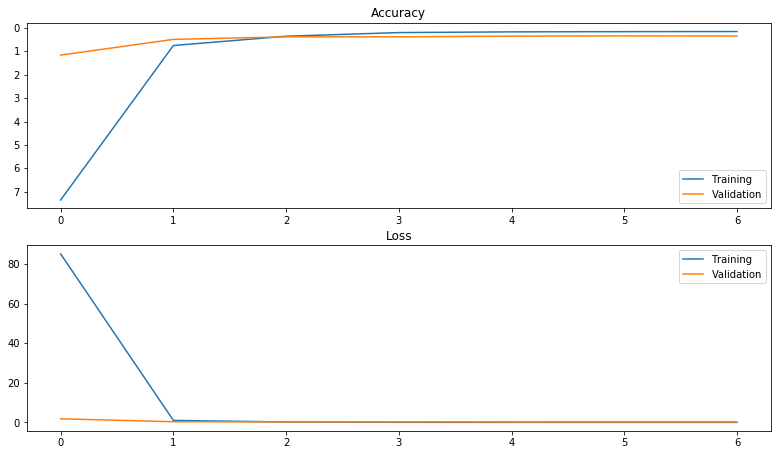

In [150]:
    # Plot accuracy and loss.
    fig = plt.figure(figsize=[26.6667*.5, 15*.5])
    plotting_grid = grid.GridSpec(2, 1)
    # Plot accuracy.
    ax1 = fig.add_subplot(plotting_grid[0, 0])
    ax1.plot(history.history['mean_absolute_error'], label='Training')
    ax1.plot(history.history['val_mean_absolute_error'], label='Validation')
    ax1.set_xticks(list(range(
        0, len(history.history['val_mean_absolute_error'])
    )))
    ax1.invert_yaxis()
    ax1.legend()
    ax1.set_title('Accuracy')
    # Plot loss.
    ax2 = fig.add_subplot(plotting_grid[1, 0])
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_xticks(list(range(
        0, len(history.history['val_mean_absolute_error'])
    )))
    ax2.legend()
    ax2.set_title('Loss')

Now, let us generate preictions out of LSTM RNN.

In [151]:
    # Generate predictions.
    lstm_rnn_predictions = lstm_rnn_model.predict_generator(
        generator=generate_batch_for_prediction(
            features=x_test_standardized,
            inventory_of_batches=testing_indices
        ),
        steps=len(testing_indices),
        verbose=1
    )

9838/9838 [==============================] - 91s 9ms/step


Just a short check, and a remainder tht we are dropping first thiry predictions becauase of design of RNN network.

In [152]:
    print(len(lstm_rnn_predictions) == len(targets_test))
    print(len(lstm_rnn_predictions) == len(targets_test[30:, ]))

False
True


Now, we can put all predictions, both from FFD ANN and LSTM RNN into a single data frame.

In [153]:
    table_for_plotting = pd.DataFrame(OrderedDict([
        ('targets', targets_test[30:].flatten()),
        ('ffd_ann_predictions', ffd_ann_predictions[30:, ]),
        ('lstm_rnn_predictions', lstm_rnn_predictions.flatten())
    ]))

Let us now compute the accuracy of the LSTM RNN.

In [154]:
    # Compute accuracy (MAE).
    lstm_rnn_mae = np.round(
        np.mean(
            np.abs(
                table_for_plotting['targets']
                - table_for_plotting['lstm_rnn_predictions']
            )
        ),
        decimals=2
    )

Now let us compare the fit of these two distinct types of networks.

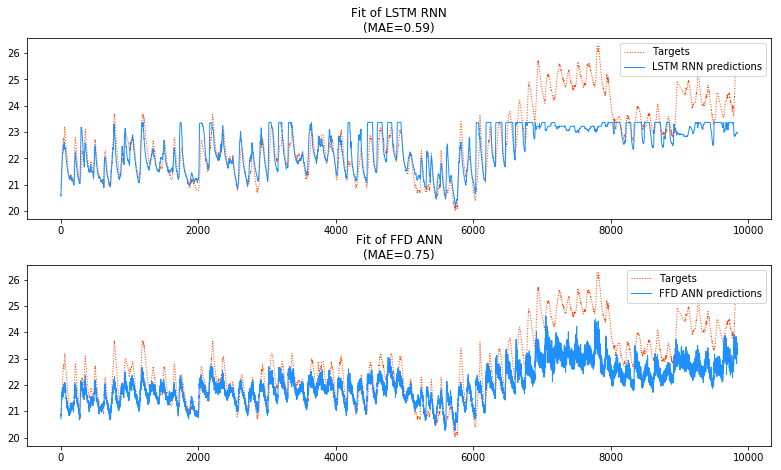

In [155]:
    # Comparison of fit.
    fig = plt.figure(figsize=[26.6667 * .5, 15 * .5])
    fig.subplots_adjust(hspace=.25)
    plotting_grid = grid.GridSpec(2, 1)
    # Plot LSTM RNN.
    ax1 = fig.add_subplot(plotting_grid[0, 0])
    ax1.plot(
        table_for_plotting['targets'],
        color='orangered',
        label='Targets',
        linestyle=':',
        linewidth=1,
    )
    ax1.plot(
        table_for_plotting['lstm_rnn_predictions'],
        color='dodgerblue',
        label='LSTM RNN predictions',
        linewidth=1
    )
    ax1.set_title(
        'Fit of LSTM RNN\n(MAE=%s)'
        %
        str(lstm_rnn_mae)
    )
    ax1.legend(loc=1)
    # Plot FFD ANN.
    ax2 = fig.add_subplot(plotting_grid[1, 0])
    ax2.plot(
        table_for_plotting['targets'],
        color='orangered',
        label='Targets',
        linestyle=':',
        linewidth=1,
    )
    ax2.plot(
        table_for_plotting['ffd_ann_predictions'],
        color='dodgerblue',
        label='FFD ANN predictions',
        linewidth=1
    )
    ax2.set_title(
        'Fit of FFD ANN\n(MAE=%s)'
        %
        str(ffd_ann_mae)
    )
    ax2.legend(loc=1)

# Conclusion

As we can see, there is obviousley a distinctive, much more suitable fit, given by the RNN with LSTM cells, in comparison to the FFD ANN. This is a consequence of a specific architecture of the RNN, which allows the network to become more skilfull in making conclusions, which take into account temporal dependance. In contrast, FFD ANN is completley unaware of temporal dependance in the data. FFD ANN makes concusions only on the basis of the inputs which are completely synchronized with the outputs in temporeal dimension, esentially downgrading time series data into transactional (i.i.d.) data. The advantages do not stop there, relative improvement in the accuracy over FFD ANN is 21%. The RNN was able to reduce MAE for 0.16 degrees of Celsius, which is one fith of the result achieved by the FFD ANN. Also, please note that the FFD ANN is heavily regularized, while there is no regularization of the LSTM RNN. However, the analysis would not be complete without two additional notes. First one is a note regarding the training time, which is several times greater when it comes to the LSTM RNN in comparison with FFD ANN. FFD ANNs fit quickly, and require no tuning of the dimension of time. Second one is the ability of FFD ANN to give a slightly better fit in the second part of the data, after there is a shift in the distribution of the input data. In this section of the data LSTM RNN is demonstrating lower fit ability, most likely because of absence of any reqularization during training process.